## Assignment Information

| Field | Details |
|-------|---------|
| **Name** | Pros Loung |
| **Course** | AAI-521 Applied Computer Vision for AI |
| **Assignment** | 3.1 - Object Detection and Segmentation |
| **GitHub Repository** | https://github.com/ploung/AAI-521-ComputerVision_Module3.git |

---

### Assignment Overview


In [ ]:
# Import necessary libraries
# ! Install tensorflow-datasets if not already installed
# !pip install tensorflow-hub
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [ ]:
# a) Load the oxford_iiit_pet dataset

dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)
train_ds = dataset['train']
test_ds = dataset['test']

# Explore the dataset
print(info) 
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")

In [ ]:
# Visualize some images from the dataset 
ImageLabel = info.features['label'].names

def ShowImage(ImageData, NumImg=2):
    '''Displays the first number of images from the dataset.'''
    print(f'Displaying {NumImg}: images')
    plt.figure(figsize=(5, 5))
    for i in range(NumImg * NumImg):
        plt.subplot(NumImg, NumImg, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        plt.imshow(ImageData[i], cmap=plt.cm.binary)
        #plt.xlabel([ImageLabel[i]])
    plt.tight_layout()
    plt.show()

train_dataset = dataset['train']
test_dataset = dataset['test']

print("Training Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in train_dataset.take(9)], NumImg=3)

print("Testing Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in test_dataset.take(9)], NumImg=3)

In [ ]:
def read_and_preprocess(data):
    input_image = data['image']  
    input_mask = data['segmentation_mask']
    
    # Resize images to 128x128
    input_image = tf.image.resize(input_image, [128, 128])
    input_mask = tf.image.resize(input_mask, [128, 128])
    
    # ! Important: Proper image normalization for display
    #input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    #input_mask -= 1 # {1,2,3} to {0,1,2}
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Normalize to [0,1]
    
    # ? Process mask properly
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask -= 1  # {1,2,3} to {0,1,2}
    
    return input_image, input_mask

In [ ]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

In [ ]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

images, masks = next(iter(train.batch(3)))

# Create a 2x3 subplot layout: images on top row, masks on bottom row
plt.figure(figsize=(8, 5))

# Display the original images on the top row
for i in range(3):
    plt.subplot(2, 3, i+1)  
    plt.imshow(images[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

# Display the masks on the bottom row
for i in range(3):
    plt.subplot(2, 3, i+4)  
    plt.imshow(masks[i], cmap='viridis')  
    plt.title(f'Segmentation Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Part 2- Annotation**

In [ ]:
# Install mrcnn if not already installed
#!pip install mrcnn

In [ ]:
# Get data from here https://github.com/experiencor/raccoon_dataset
# Uncomment to clone git repo
# !git clone https://github.com/experiencor/raccoon_dataset

In [28]:
# Load dataset and plot some sample images

import os

def load_images(dataset_path='None'):
    """Create method images from the dataset directory"""
    images_path = os.path.join(dataset_path, 'images')
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    images = []
    image_names = []
    
    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)
        
        # Load image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        images.append(image)
        image_names.append(image_file)
    
    print(f"Loaded {len(images)} images")
    return images, image_names

def plot_images(images, num_images=6):
    """Create method to plot sample images from the dataset"""
    plt.figure(figsize=(8, 5))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Loaded 200 images


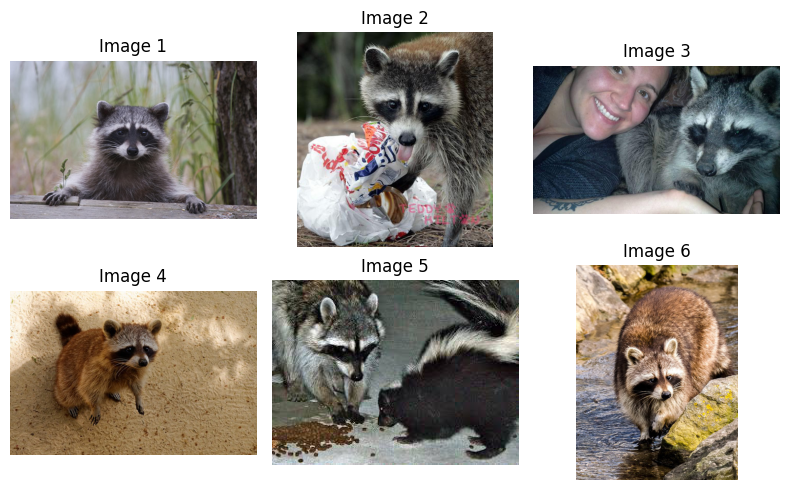

In [29]:
# Load the Raccoon dataset images
images, names = load_images('raccoon_dataset')

# Plot sample images from the Raccoon dataset
plot_images(images, num_images=6)

In [31]:
# !pip install scipy scikit-image
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


Loaded 200 images


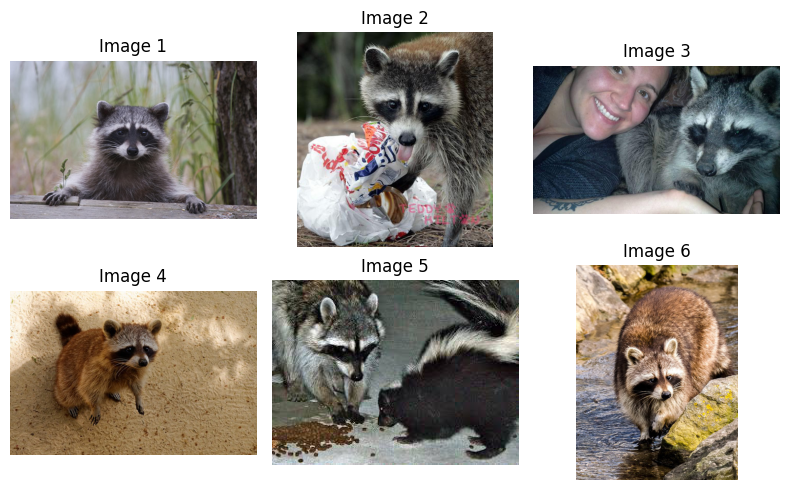

In [ ]:
# load an image
# Use the function above to create the image and its mask
